In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tushare as ts
import torch
from torch import nn

In [52]:
#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']

plt.rcParams['axes.unicode_minus'] = False

# 1000迭代——固定长度=5

In [2]:
DAYS_FOR_TRAIN = 5
EPOCHS = 1000

In [3]:
class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x

In [4]:
def create_dataset(data, days_for_train=DAYS_FOR_TRAIN) -> (np.array, np.array):
    """
        根据给定的序列data，生成数据集。
        数据集分为输入和输出，每一个输入的长度为days_for_train，每一个输出的长度为1。
        也就是说用days_for_train天的数据，对应下一天的数据。
        若给定序列的长度为d，将输出长度为(d-days_for_train)个输入/输出对
    """
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train)]
        dataset_x.append(_x)
        dataset_y.append(data[i + days_for_train])
    return (np.array(dataset_x), np.array(dataset_y))

In [17]:
def cal_MAE_MSE(a,b):
    if len(a)!=len(b):
        return "error"
    
    sum1 = 0
    sum2 = 0
    for i in range(len(a)):
        sum1 += (a[i]-b[i])**2
    
        sum2 += abs(a[i]-b[i])
    
    sum1 = sum1/len(a)
    sum2 = sum2/len(a)
    return [sum1,sum2]

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


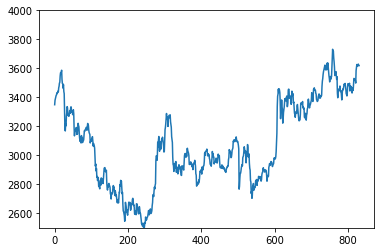

Epoch: 100, Loss:0.00593
Epoch: 200, Loss:0.00282
Epoch: 300, Loss:0.00255
Epoch: 400, Loss:0.00247
Epoch: 500, Loss:0.00244
Epoch: 600, Loss:0.00241
Epoch: 700, Loss:0.00238
Epoch: 800, Loss:0.00235
Epoch: 900, Loss:0.00232
Epoch: 1000, Loss:0.00225


In [5]:
if __name__ == '__main__':
    # 取上证指数的收盘价
    share_prices = ts.get_k_data('000001', start='2018-01-01', index=True)['high'].values
    share_prices = share_prices.astype('float32')  # 转换数据类型: obj ->float
    # 上证指数收盘价作图
    plt.plot(share_prices)
    plt.savefig('share_prices.png', format='png', dpi=200)
    plt.ylim(2500, 4000)
    plt.draw()
    plt.show()
    plt.close()
    # 将数据集标准化到 [-1,1] 区间
    scaler = MinMaxScaler(feature_range=(-1, 1))  # train data normalized
    share_prices = scaler.fit_transform(share_prices.reshape(-1, 1))
    # 数据集序列化，进行标签分离
    dataset_x, dataset_y = create_dataset(share_prices, DAYS_FOR_TRAIN)
    # 划分训练集和测试集,70%作为训练集,30%作为测试集
    train_size = int(len(dataset_x) * 0.7)
    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    test_x = dataset_x[train_size:]
    test_y = dataset_y[train_size:]
    # 改变数据集形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
    train_x = train_x.reshape(-1, 1, DAYS_FOR_TRAIN)
    train_y = train_y.reshape(-1, 1, 1)
    # 数据集转为pytorch的tensor对象
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    # train model
    model = LSTM_Regression(DAYS_FOR_TRAIN, 8, output_size=1, num_layers=2)  # 网络初始化
    loss_function = nn.MSELoss()  # 损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # 优化器
    for epoch in range(EPOCHS):
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (epoch + 1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch + 1, loss.item()))
    # torch.save(model.state_dict(), 'model_params.pkl')  # 可以保存模型的参数供未来使用
    # predict
    model = model.eval()  # 转换成测试模式
    # model.load_state_dict(torch.load('model_params.pkl'))  # 读取参数
    # 使用全部数据集dataset_x,模型的输出长度会比dataset_x少 DAYS_FOR_TRAIN
    dataset_x = dataset_x.reshape(-1, 1, DAYS_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
    dataset_x = torch.from_numpy(dataset_x)  # 转为pytorch的tensor对象
    pred_y = model(dataset_x)  # 全量数据集的模型输出 (seq_size, batch_size, output_size)
    pred_y = pred_y.view(-1).data.numpy()
    # 对标准化数据进行还原
    actual_pred_y = scaler.inverse_transform(pred_y.reshape(-1, 1))
    actual_pred_y = actual_pred_y.reshape(-1, 1).flatten()
    test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
    test_y = test_y.reshape(-1, 1).flatten()
    actual_pred_y = actual_pred_y[-len(test_y):]
    test_y = test_y.reshape(-1, 1)
    assert len(actual_pred_y) == len(test_y)

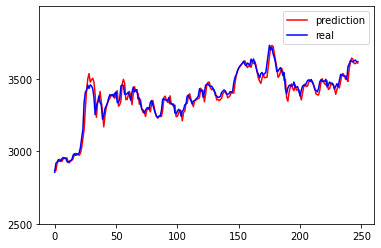

In [7]:
# 初始结果 - 预测结果
#my_x_ticks = np.arange(-5, 5, 0.5) #设X轴标签
my_y_ticks = np.arange(0, 4000,500) #设Y轴标签
#plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.plot(actual_pred_y, 'r', label='prediction')
plt.plot(test_y, 'b', label='real')
plt.plot((len(actual_pred_y), len(test_y)), (0, 1), 'g--')  # 分割线 左边是训练数据 右边是测试数据的输出
plt.legend(loc='best')
plt.ylim(2500, 4000) #设Y轴范围
plt.savefig('result.png', format='png', dpi=200)
plt.draw()
plt.show()
plt.close()

In [12]:
#actual_pred_y = [x[0] for x in actual_pred_y]
test_y = [x[0] for x in test_y]

In [14]:
import pandas as pd
df_5 = pd.DataFrame({'actual_pred_y':actual_pred_y, 'test_y':test_y})
df_5.to_csv("上证_5_1000.csv")
df_5

,actual_pred_y,test_y
0,2869.516113,2855.379883
1,2865.885742,2917.149658
2,2917.556152,2926.360352
3,2932.157959,2942.760010
4,2945.679688,2932.969971
...,...,...
243,3635.093262,3615.659912
244,3605.345947,3626.070068
245,3605.224365,3629.290039
246,3612.625000,3618.510010


In [18]:
cal_MAE_MSE(actual_pred_y,test_y)

[1527.0604967830643, 28.32909959362399]

In [19]:
share_prices = ts.get_k_data('000001', start='2018-01-01', index=True)['high'].values
data_init = share_prices
print(len(share_prices)-len(df_5))
print(len(data_init))


本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


Text(0.5, 1.0, '上证指数：LSTM模型（输入长度为5天）预测结果')

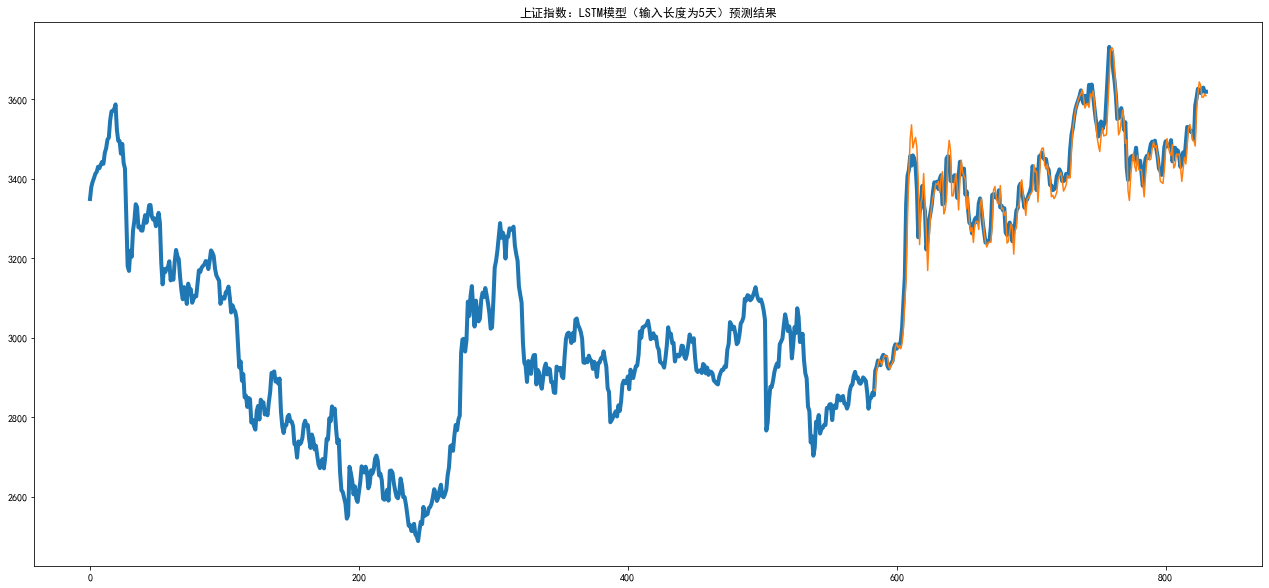

In [53]:
plt.figure(figsize=(22,10))
plt.plot(data_init,lw = 4)
plt.plot(range(583,831),actual_pred_y)
plt.title("上证指数：LSTM模型（输入长度为5天）预测结果")

# 1000迭代——固定长度=10¶

In [73]:
DAYS_FOR_TRAIN = 10
EPOCHS = 1000

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


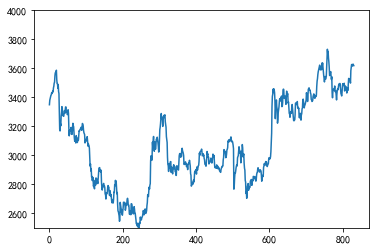

Epoch: 100, Loss:0.00599
Epoch: 200, Loss:0.00275
Epoch: 300, Loss:0.00237
Epoch: 400, Loss:0.00227
Epoch: 500, Loss:0.00221
Epoch: 600, Loss:0.00217
Epoch: 700, Loss:0.00213
Epoch: 800, Loss:0.00207
Epoch: 900, Loss:0.00193
Epoch: 1000, Loss:0.00182


In [74]:
if __name__ == '__main__':
    # 取上证指数的收盘价
    share_prices = ts.get_k_data('000001', start='2018-01-01', index=True)['high'].values
    share_prices = share_prices.astype('float32')  # 转换数据类型: obj ->float
    # 上证指数收盘价作图
    plt.plot(share_prices)
    plt.savefig('share_prices.png', format='png', dpi=200)
    plt.ylim(2500, 4000)
    plt.draw()
    plt.show()
    plt.close()
    # 将数据集标准化到 [-1,1] 区间
    scaler = MinMaxScaler(feature_range=(-1, 1))  # train data normalized
    share_prices = scaler.fit_transform(share_prices.reshape(-1, 1))
    # 数据集序列化，进行标签分离
    dataset_x, dataset_y = create_dataset(share_prices, DAYS_FOR_TRAIN)
    # 划分训练集和测试集,70%作为训练集,30%作为测试集
    train_size = int(len(dataset_x) * 0.7)
    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    test_x = dataset_x[train_size:]
    test_y = dataset_y[train_size:]
    # 改变数据集形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
    train_x = train_x.reshape(-1, 1, DAYS_FOR_TRAIN)
    train_y = train_y.reshape(-1, 1, 1)
    # 数据集转为pytorch的tensor对象
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    # train model
    model = LSTM_Regression(DAYS_FOR_TRAIN, 8, output_size=1, num_layers=2)  # 网络初始化
    loss_function = nn.MSELoss()  # 损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # 优化器
    for epoch in range(EPOCHS):
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (epoch + 1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch + 1, loss.item()))
    # torch.save(model.state_dict(), 'model_params.pkl')  # 可以保存模型的参数供未来使用
    # predict
    model = model.eval()  # 转换成测试模式
    # model.load_state_dict(torch.load('model_params.pkl'))  # 读取参数
    # 使用全部数据集dataset_x,模型的输出长度会比dataset_x少 DAYS_FOR_TRAIN
    dataset_x = dataset_x.reshape(-1, 1, DAYS_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
    dataset_x = torch.from_numpy(dataset_x)  # 转为pytorch的tensor对象
    pred_y = model(dataset_x)  # 全量数据集的模型输出 (seq_size, batch_size, output_size)
    pred_y = pred_y.view(-1).data.numpy()
    # 对标准化数据进行还原
    actual_pred_y = scaler.inverse_transform(pred_y.reshape(-1, 1))
    actual_pred_y = actual_pred_y.reshape(-1, 1).flatten()
    test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
    test_y = test_y.reshape(-1, 1).flatten()
    actual_pred_y = actual_pred_y[-len(test_y):]
    test_y = test_y.reshape(-1, 1)
    assert len(actual_pred_y) == len(test_y)

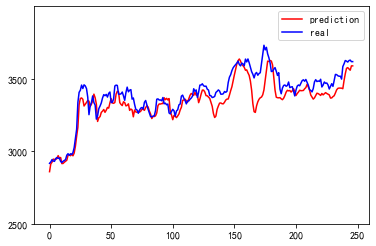

In [75]:
# 初始结果 - 预测结果
#my_x_ticks = np.arange(-5, 5, 0.5) #设X轴标签
my_y_ticks = np.arange(0, 4000,500) #设Y轴标签
#plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.plot(actual_pred_y, 'r', label='prediction')
plt.plot(test_y, 'b', label='real')
plt.plot((len(actual_pred_y), len(test_y)), (0, 1), 'g--')  # 分割线 左边是训练数据 右边是测试数据的输出
plt.legend(loc='best')
plt.ylim(2500, 4000) #设Y轴范围
plt.savefig('result.png', format='png', dpi=200)
plt.draw()
plt.show()
plt.close()

In [76]:
#actual_pred_y = [x[0] for x in actual_pred_y]
test_y = [x[0] for x in test_y]

In [77]:
df_10 = pd.DataFrame({'actual_pred_y':actual_pred_y, 'test_y':test_y})
df_10.to_csv("上证_10_1000.csv")
df_10

,actual_pred_y,test_y
0,2859.546875,2917.149658
1,2912.943848,2926.360352
2,2924.600830,2942.760010
3,2946.262695,2932.969971
4,2943.603760,2930.800049
...,...,...
242,3577.149170,3615.659912
243,3567.812256,3626.070068
244,3559.481201,3629.290039
245,3589.505127,3618.510010


In [78]:
cal_MAE_MSE(actual_pred_y,test_y)

[6991.250016541858, 64.24922408748735]

No handles with labels found to put in legend.


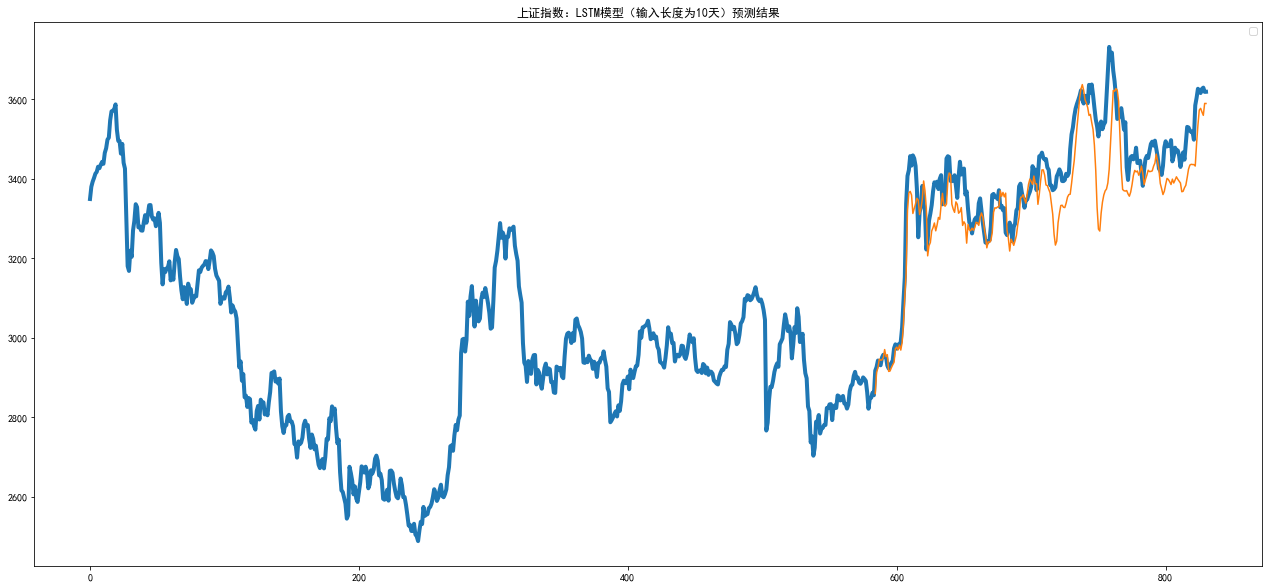

In [79]:
plt.figure(figsize=(22,10))
plt.plot(data_init,lw = 4)
plt.plot(range(584,831),actual_pred_y)
plt.title("上证指数：LSTM模型（输入长度为10天）预测结果")
plt.legend(loc='best')

# 1000迭代——固定长度=20

In [64]:
DAYS_FOR_TRAIN = 20
EPOCHS = 1000

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2


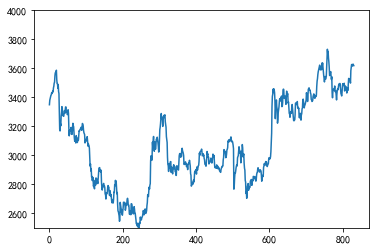

Epoch: 100, Loss:0.00589
Epoch: 200, Loss:0.00255
Epoch: 300, Loss:0.00227
Epoch: 400, Loss:0.00214
Epoch: 500, Loss:0.00194
Epoch: 600, Loss:0.00193
Epoch: 700, Loss:0.00168
Epoch: 800, Loss:0.00159
Epoch: 900, Loss:0.00358
Epoch: 1000, Loss:0.00218


In [65]:
if __name__ == '__main__':
    # 取上证指数的收盘价
    share_prices = ts.get_k_data('000001', start='2018-01-01', index=True)['high'].values
    share_prices = share_prices.astype('float32')  # 转换数据类型: obj ->float
    # 上证指数收盘价作图
    plt.plot(share_prices)
    plt.savefig('share_prices.png', format='png', dpi=200)
    plt.ylim(2500, 4000)
    plt.draw()
    plt.show()
    plt.close()
    # 将数据集标准化到 [-1,1] 区间
    scaler = MinMaxScaler(feature_range=(-1, 1))  # train data normalized
    share_prices = scaler.fit_transform(share_prices.reshape(-1, 1))
    # 数据集序列化，进行标签分离
    dataset_x, dataset_y = create_dataset(share_prices, DAYS_FOR_TRAIN)
    # 划分训练集和测试集,70%作为训练集,30%作为测试集
    train_size = int(len(dataset_x) * 0.7)
    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    test_x = dataset_x[train_size:]
    test_y = dataset_y[train_size:]
    # 改变数据集形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
    train_x = train_x.reshape(-1, 1, DAYS_FOR_TRAIN)
    train_y = train_y.reshape(-1, 1, 1)
    # 数据集转为pytorch的tensor对象
    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    # train model
    model = LSTM_Regression(DAYS_FOR_TRAIN, 8, output_size=1, num_layers=2)  # 网络初始化
    loss_function = nn.MSELoss()  # 损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # 优化器
    for epoch in range(EPOCHS):
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (epoch + 1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch + 1, loss.item()))
    # torch.save(model.state_dict(), 'model_params.pkl')  # 可以保存模型的参数供未来使用
    # predict
    model = model.eval()  # 转换成测试模式
    # model.load_state_dict(torch.load('model_params.pkl'))  # 读取参数
    # 使用全部数据集dataset_x,模型的输出长度会比dataset_x少 DAYS_FOR_TRAIN
    dataset_x = dataset_x.reshape(-1, 1, DAYS_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
    dataset_x = torch.from_numpy(dataset_x)  # 转为pytorch的tensor对象
    pred_y = model(dataset_x)  # 全量数据集的模型输出 (seq_size, batch_size, output_size)
    pred_y = pred_y.view(-1).data.numpy()
    # 对标准化数据进行还原
    actual_pred_y = scaler.inverse_transform(pred_y.reshape(-1, 1))
    actual_pred_y = actual_pred_y.reshape(-1, 1).flatten()
    test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
    test_y = test_y.reshape(-1, 1).flatten()
    actual_pred_y = actual_pred_y[-len(test_y):]
    test_y = test_y.reshape(-1, 1)
    assert len(actual_pred_y) == len(test_y)

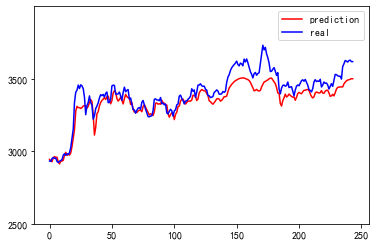

In [66]:
# 初始结果 - 预测结果
#my_x_ticks = np.arange(-5, 5, 0.5) #设X轴标签
my_y_ticks = np.arange(0, 4000,500) #设Y轴标签
#plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

plt.plot(actual_pred_y, 'r', label='prediction')
plt.plot(test_y, 'b', label='real')
plt.plot((len(actual_pred_y), len(test_y)), (0, 1), 'g--')  # 分割线 左边是训练数据 右边是测试数据的输出
plt.legend(loc='best')
plt.ylim(2500, 4000) #设Y轴范围
plt.savefig('result.png', format='png', dpi=200)
plt.draw()
plt.show()
plt.close()

In [67]:
#actual_pred_y = [x[0] for x in actual_pred_y]
test_y = [x[0] for x in test_y]

In [68]:
df_20 = pd.DataFrame({'actual_pred_y':actual_pred_y, 'test_y':test_y})
df_20.to_csv("上证_20_1000.csv")
df_20

,actual_pred_y,test_y
0,2944.341064,2932.969971
1,2933.591309,2930.800049
2,2928.336670,2950.070312
3,2956.275635,2957.120117
4,2963.572266,2951.329834
...,...,...
239,3491.443359,3615.659912
240,3493.932861,3626.070068
241,3496.478271,3629.290039
242,3501.506592,3618.510010


In [69]:
cal_MAE_MSE(actual_pred_y,test_y)

[6192.183572427904, 62.053089579597845]

No handles with labels found to put in legend.


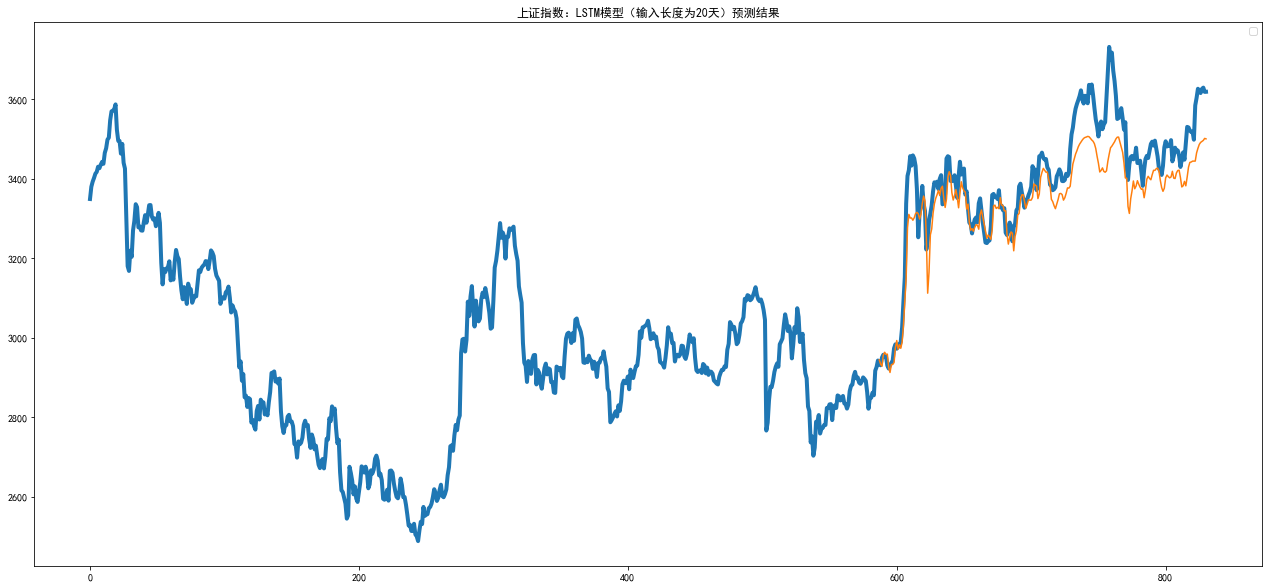

In [72]:
plt.figure(figsize=(22,10))
plt.plot(data_init,lw = 4)
plt.plot(range(587,831),actual_pred_y)
plt.title("上证指数：LSTM模型（输入长度为20天）预测结果")
plt.legend(loc='best')